In [1]:
import warnings
warnings.filterwarnings("ignore")

Create Dataset

In [269]:
import pandas as pd
import numpy as np

first_df=pd.read_csv('Arrests_cleaned.csv')

In [3]:
import requests, json
r = requests.get('https://data.cityofchicago.org/resource/crimes.json?$limit=600000')
data = r.json()
sec_df = pd.DataFrame(data)
sec_df = sec_df[['case_number','ward','district']]

In [271]:
merged_df = pd.merge(first_df, sec_df, on="case_number")
print(len(merged_df))
merged_df.head(1)

68416


,id,case_number,date_month,date_day,date_year,time,meridiem,race,charge_1_statute,charge_1_description,...,charge_4_statute,charge_4_description,charge_4_type,charge_4_class,CHARGES STATUTE,CHARGES DESCRIPTION,CHARGES TYPE,CHARGES CLASS,ward,district
0,30039812,JE183770,3,30,2021,12:10:00,AM,WHITE HISPANIC,720 ILCS 5.0/12-3.2-A-1,DOMESTIC BATTERY - BODILY HARM,...,NaN,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-1 | | |,DOMESTIC BATTERY - BODILY HARM | | |,M | | |,A | | |,14,008


In [272]:
races = merged_df.loc[:, "race"].unique().tolist()
race_dummies = pd.get_dummies(merged_df, columns=["race"])
races = ["race_"+r for r in races]
race_dummies = race_dummies[races]
race_dummies

,race_WHITE HISPANIC,race_BLACK,race_BLACK HISPANIC,race_WHITE,race_ASIAN / PACIFIC ISLANDER,race_AMER INDIAN / ALASKAN NATIVE,race_UNKNOWN / REFUSED
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
68411,0,0,1,0,0,0,0
68412,0,1,0,0,0,0,0
68413,0,1,0,0,0,0,0
68414,1,0,0,0,0,0,0


In [275]:
merged_df = merged_df[['ward','district','date_day','charge_1_type','time','meridiem']]

merged_df = pd.concat([merged_df, race_dummies], axis=1).dropna()

In [276]:
merged_df

,ward,district,date_day,charge_1_type,time,meridiem,race_WHITE HISPANIC,race_BLACK,race_BLACK HISPANIC,race_WHITE,race_ASIAN / PACIFIC ISLANDER,race_AMER INDIAN / ALASKAN NATIVE,race_UNKNOWN / REFUSED
0,14,008,30.0,M,12:10:00,AM,1,0,0,0,0,0,0
1,22,010,23.0,M,12:04:00,AM,0,1,0,0,0,0,0
2,7,004,16.0,F,9:36:00,PM,0,1,0,0,0,0,0
3,24,011,16.0,F,12:19:00,PM,0,1,0,0,0,0,0
4,13,008,16.0,M,4:24:00,AM,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68411,22,010,7.0,F,6:20:00,PM,0,0,1,0,0,0,0
68412,34,022,7.0,M,5:40:00,PM,0,1,0,0,0,0,0
68413,9,005,7.0,F,9:35:00,PM,0,1,0,0,0,0,0
68414,7,003,7.0,F,7:16:00,PM,1,0,0,0,0,0,0


In [278]:
from sklearn.model_selection import train_test_split

X = merged_df[['race_WHITE HISPANIC','race_BLACK','race_BLACK HISPANIC','race_WHITE','race_ASIAN / PACIFIC ISLANDER','race_AMER INDIAN / ALASKAN NATIVE', \
    'race_UNKNOWN / REFUSED','ward','district','date_day']]
y = merged_df[['charge_1_type']]

#### Ensemble

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)
y_bool_train = [i == "M" for i in y_train['charge_1_type']]
y_bool_test = [i == "M" for i in y_test['charge_1_type']]

In [280]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [281]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy')
decision_tree_model.fit(X_train, y_bool_train)
y_pred = decision_tree_model.predict(X_test)
cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
cv_results

{'fit_time': array([0.15995908, 0.13811183, 0.13181162, 0.12907386, 0.13488793]),
 'score_time': array([0.0214889 , 0.02470899, 0.01994228, 0.01791   , 0.01788402]),
 'test_score': array([0.57920702, 0.57642759, 0.58428506, 0.58492462, 0.58693467])}

In [16]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy')
best_depth = []
best_min_samples = []
best_nodes = [] 

for i in range(1,21):
    decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    decision_tree_model.fit(X_train, y_bool_train)
    y_pred = decision_tree_model.predict(X_train)
    cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
    score = np.mean(cv_results['test_score'])
    best_min_samples.append(score)
    print(score)

0.5480392845078506
0.57122761457738
0.5917113848564451
0.5948909806578195
0.6001351290779429
0.6008660914993051
0.6084675808322545
0.6113729853860436
0.6100939392909934
0.6079925581764944
0.6058729072166807
0.6016700999140513
0.59511004685404
0.5946533274314699
0.5912363071106909
0.5854072598762796
0.5820267892624927
0.5778788749654957
0.5759053660742628
0.5760332950569168


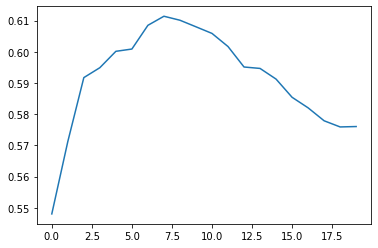

In [17]:
import matplotlib.pyplot as plt
x = list(range(20))
best_min_samples 

plt.plot(x, best_min_samples)

In [18]:
best_min_samples.index(max(best_min_samples))

7

In [19]:
for i in range(20,200,5):
    decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 7, max_leaf_nodes=i)
    decision_tree_model.fit(X_train, y_bool_train)
    y_pred = decision_tree_model.predict(X_train)
    cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
    score = np.mean(cv_results['test_score'])
    best_nodes.append(score)

In [20]:
best_nodes.index(max(best_nodes))

14

In [282]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 7, max_leaf_nodes=70)
decision_tree_model.fit(X_train, y_bool_train)
y_pred = decision_tree_model.predict(X_train)
cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
score = np.mean(cv_results['test_score'])
score

0.6062200342776621

In [283]:
from sklearn.ensemble import BaggingClassifier

In [284]:
clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70))

In [285]:
clf.fit(X_train, y_bool_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=7,
                                                        max_leaf_nodes=70))

In [286]:
cv_results = cross_validate(clf, X_train, y_bool_train)
cv_results

{'fit_time': array([0.87552881, 0.70612288, 0.71280217, 0.74763799, 0.72725296]),
 'score_time': array([0.10379124, 0.10676718, 0.10222578, 0.10835099, 0.10497999]),
 'test_score': array([0.61054266, 0.59908634, 0.61169484, 0.60977615, 0.61617177])}

In [287]:
y_pred = clf.predict(X_test)

In [288]:
f1_score(y_bool_test,y_pred)

0.6572968810165576

In [219]:
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf3 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf4 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf5 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf6 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf7 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf8 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf9 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf10 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')

In [28]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier

In [111]:
eclf1 = VotingClassifier(estimators=[('clf1', clf1), 
                                     ('clf2', clf2), 
                                     ('clf3', clf3), 
                                     ('clf4', clf4), 
                                     ('clf5', clf5), 
                                     ('clf6', clf6), 
                                     ('clf7', clf7), 
                                     ('clf8', clf8), 
                                     ('clf9', clf9), 
                                     ('clf10', clf10)], voting='hard')

In [112]:
eclf1 = eclf1.fit(X_train, y_bool_train)

In [113]:
eclf1.predict(X_train)

array([ True,  True, False, ...,  True,  True,  True])

In [114]:
cv_results = cross_validate(eclf1, X_train, y_bool_train)
cv_results

{'fit_time': array([0.45018387, 0.45768785, 0.43303204, 0.53504992, 0.43419909]),
 'score_time': array([0.13137412, 0.12763619, 0.12238693, 0.13361001, 0.11560011]),
 'test_score': array([0.60423899, 0.59890361, 0.61251713, 0.60420283, 0.60493376])}

In [115]:
y_pred = eclf1.predict(X_test)

In [116]:
f1_score(y_bool_test,y_pred)

0.6363758569700229

In [42]:
aclf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt'))
aclf.fit(X_train,y_bool_train)
aclf.score(X_test,y_bool_test)

0.604443794766847

In [43]:
y_pred = aclf.predict(X_test)

In [44]:
f1_score(y_bool_test,y_pred)

0.6179045467382096

In [45]:
rclf = RandomForestClassifier()
rclf.fit(X_train,y_bool_train)
rclf.score(X_test,y_bool_test)

0.5909954684987575

In [46]:
y_pred = rclf.predict(X_test)

In [47]:
f1_score(y_bool_test,y_pred)

0.5909954684987575

In [48]:
eclf = ExtraTreesClassifier()
eclf.fit(X_train,y_bool_train)
eclf.score(X_test,y_bool_test)

0.5863908785265312

In [49]:
y_pred = eclf.predict(X_test)

In [50]:
f1_score(y_bool_test,y_pred)

0.5635171615888932

In [51]:
hclf = HistGradientBoostingClassifier()
hclf.fit(X_train,y_bool_train)
hclf.score(X_test,y_bool_test)

0.6141645958193247

In [52]:
y_pred = eclf.predict(X_test)

In [53]:
f1_score(y_bool_test,y_pred)

0.5635171615888932

In [54]:
estimators = [('dt', DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')),('rf',RandomForestClassifier())]
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_train,y_bool_train)
sclf.score(X_test,y_bool_test)

0.601447156848414

In [55]:
y_pred = sclf.predict(X_test)

In [56]:
f1_score(y_bool_test,y_pred)

0.625249123771562